In [1]:
import preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import sqlite3
import seaborn as sns
import graphviz 
import matplotlib.pyplot as plt

In [2]:
filePath="./data/financial.db"
# dataframe = preprocessing.loadAllData(filePath)

In [169]:
def extractXYValues(df, yVectorName):
    notNanDF = df[ df[yVectorName].notna() ]
    yValues = notNanDF[yVectorName]
    xValues = notNanDF.loc[:, notNanDF.columns != yVectorName] 

    one_hot_Xdata = pd.get_dummies(xValues)

    return (one_hot_Xdata, yValues)

def getTrainTestSplit(xValues, yValues): 
    X_train, X_test, y_train, y_test = train_test_split(xValues, yValues, test_size=0.30)

    return (X_train, X_test, y_train, y_test)

def accChangeToDemo(filepath):
    """
        Creates column to be added to demographic table. Column is taken from the 
        summed difference of the median account balances by district (1994-1998)
        relative to the median account value in all data in 1994.
    Args:
        filepath (str): path to financial.db.
    """
    conn = sqlite3.connect(filepath)
    accdist = pd.read_sql_query("SELECT account_id, district_id from account", conn)
    df = pd.read_sql_query("SELECT date as 'y-m-d', balance, account_id from trans ", conn)
    from datetime import date
    df['y-m-d'] = pd.to_datetime(df['y-m-d'])
    df['year'] = df['y-m-d'].map(lambda x: x.strftime('%Y'))
    df = pd.merge(accdist, df, on='account_id')
    
    # Gets the average value of each account per id per district per year
    acctMedianPerAcctPerYearPerDistrict = df.groupby(['year', 'district_id', 'account_id'])[['balance']].median()

    # Calculates median/average account balance of each district per year
    medianAcct = acctMedianPerAcctPerYearPerDistrict.groupby(['year', 'district_id'])[['balance']].median()
    avgAcct = acctMedianPerAcctPerYearPerDistrict.groupby(['year', 'district_id'])[['balance']].mean()
    
    
    # Gets difference of each account's median per year
#     districtchange = medianAcct.groupby(['district_id'])[['balance']].diff().fillna(0)
    
    medianChange93to98 = (medianAcct.loc['1998'] - medianAcct.loc['1993']) / medianAcct.loc['1993']
    meanChange93to98 = (medianAcct.loc['1998'] - medianAcct.loc['1993']) / medianAcct.loc['1993']
    acctMedianPerAcctPerYearPerDistrictChange = (acctMedianPerAcctPerYearPerDistrict.loc['1998']- acctMedianPerAcctPerYearPerDistrict.loc['1996'])/ acctMedianPerAcctPerYearPerDistrict.loc['1996']

    return (acctMedianPerAcctPerYearPerDistrict.reset_index(), medianAcct.reset_index(), avgAcct.reset_index(), medianChange93to98.reset_index(), meanChange93to98.reset_index(), acctMedianPerAcctPerYearPerDistrictChange.reset_index()) 

def categorizeGrowth(growthRate): 
    if growthRate > 10: 
        return 0
    elif growthRate >= 0: 
        return 1
    elif growthRate >= -10:
        return 2
    else: 
        return 3


def doKfoldCrossValidation(X,y, model, isRegression):     
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    errorRates = []
    errorDifferences = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        mlModel = model()
        mlModel.fit(X_train, y_train)
        y_test_pred = mlModel.score(X_test, y_test)
        errorRates.append(y_test_pred)

        # Save off y_test_pred in a list or something -- you can average it all when done
        
        if isRegression: 
            errorDifferences.append( np.mean(np.abs(y_test.reshape((len(y_test),)) - y_test_pred) ))
        else: 
            errorDifferences.append( 0 )
        

    return ( np.mean(errorRates), np.mean(errorDifferences) )


def getDataFrame(filePath): 
    (acctMedianPerAcctPerYearPerDistrict, medianPerDistrictDF, averagePerDistrictDF, medianChange93to98, meanChange93to98, acctMedianPerAcctPerYearPerDistrict93to98) = accChangeToDemo(filePath)
    conn = sqlite3.connect(filePath)
    districtDFNoNames = pd.read_sql_query("SELECT * from district", conn)
    districtDFNoNames.at[68,'A12'] = districtDFNoNames.at[68,'A13'] 
    districtDFNoNames.at[68,'A15'] = districtDFNoNames.at[68,'A16']
    
    conn.close()
    districtDF = updateColumnNames(districtDFNoNames)
    districtDF.drop(['districtName', 'region'], axis=1, inplace=True)
    
    dfAccts = districtDF.merge(acctMedianPerAcctPerYearPerDistrict, on=["district_id"])
    medianPerDistAccts = districtDF.merge(medianPerDistrictDF, on=["district_id"])
    meanPerDistAccts =  districtDF.merge(averagePerDistrictDF, on=["district_id"])
    medianPerDistChange93to98 =  districtDF.merge(medianChange93to98, on=["district_id"])
    meanPerDistChange93to98 =  districtDF.merge(meanChange93to98, on=["district_id"])
    dfAcctsChange93to98 =  districtDF.merge(acctMedianPerAcctPerYearPerDistrict93to98, on=["district_id"])


    
    return (dfAccts,medianPerDistAccts,meanPerDistAccts, medianPerDistChange93to98, meanPerDistChange93to98, dfAcctsChange93to98)

def getAccuracy(X,y, model, isRegression): 
    xTrain, xTest, yTrain, yTest = getTrainTestSplit(X,y)
    modelObject = model()
    modelObject.fit(xTrain, yTrain)
    yPredicted = modelObject.predict(xTest)
    
    if isRegression: 
        return (modelObject, metrics.mean_squared_error(yTest, yPredicted))
    else:
        return (modelObject, metrics.accuracy_score(yTest,yPredicted))


def applyModelToDataframe(df, xColumnsArray, yVectorName, model, isRegression, classifierType='linear'): 

    X = df[xColumnsArray].values
    y = df[yVectorName].values.reshape((len(df[yVectorName],)))

    (kFoldAccuracy, kfoldDifferences ) = doKfoldCrossValidation(X,y, model, isRegression)
    (modelObject, accuracy) = getAccuracy(X,y, model, isRegression)
    
    if classifierType=='randomForest':
        printImportance(modelObject, X)
    elif classifierType == 'decisionTree': 
        plt.figure(figsize=(15,15)) 
        plot_tree(modelObject, fontsize=12)
        plt.show()
    
    return { "kFoldAccuracyScore": kFoldAccuracy, "MeanSquareError": accuracy, "meanOfDifferencesInPrediction": kfoldDifferences } if isRegression else {
        "kFoldAccuracyScore": kFoldAccuracy, "classificationAcc": accuracy, "meanOfDifferencesInPrediction": kfoldDifferences }

def updateColumnNames(df): 
    columnNames = ['district_id','districtName','region', 'numInhabitants', 
                   'municipalitiesLess500','municipalities500to2k','municipalities2kto10k',
                   'municipalitiesGreater10k','numCities','ratioUrbanInhabitants','avgSalary',
                   'unEmployment95','unEmployment96','entrepeneursPer1k','crimesIn95','crimesIn96' ] 
    df.columns = columnNames
        
    return df

def printImportance(model, X): 
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
            color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [148]:
dfAcct, medianPerDistrict, meanPerDistrict, medianChange, meanChange, dfAcctsPctChange = getDataFrame(filePath)
allXColumns = ['district_id','numInhabitants', 'municipalitiesLess500','municipalities500to2k','municipalities2kto10k','municipalitiesGreater10k','numCities',                   
           'ratioUrbanInhabitants','avgSalary','unEmployment95','unEmployment96', 'entrepeneursPer1k', 'crimesIn95', 'crimesIn96' ] 
yVector = ['balance']

Feature ranking:
1. feature 10 (0.155173)
2. feature 11 (0.107381)
3. feature 9 (0.087372)
4. feature 0 (0.078602)
5. feature 1 (0.074827)
6. feature 7 (0.071502)
7. feature 8 (0.070366)
8. feature 4 (0.068663)
9. feature 2 (0.060046)
10. feature 12 (0.050377)
11. feature 13 (0.049895)
12. feature 6 (0.045307)
13. feature 3 (0.041419)
14. feature 5 (0.039069)


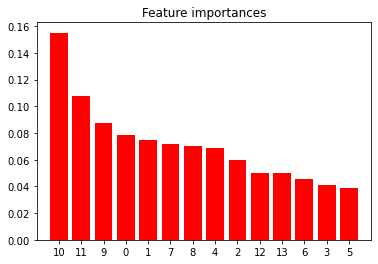

{'kFoldAccuracyScore': 0.0004764533134883564,
 'MeanSquareError': 293674329.4551945,
 'meanOfDifferencesInPrediction': 34503.22951175728}

In [149]:
randomForestAccuracy = applyModelToDataframe(dfAcct, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy

Feature ranking:
1. feature 7 (0.125163)
2. feature 11 (0.091223)
3. feature 2 (0.087724)
4. feature 3 (0.080466)
5. feature 0 (0.074684)
6. feature 10 (0.074642)
7. feature 12 (0.070118)
8. feature 13 (0.068554)
9. feature 1 (0.067363)
10. feature 4 (0.064731)
11. feature 9 (0.055222)
12. feature 8 (0.048860)
13. feature 6 (0.048111)
14. feature 5 (0.043137)


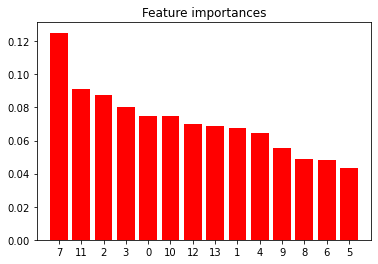

{'kFoldAccuracyScore': -0.009993807934229704,
 'MeanSquareError': 14190837.223973675,
 'meanOfDifferencesInPrediction': 31044.75031054472}

In [150]:
randomForestAccuracy = applyModelToDataframe(medianPerDistrict, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy

Feature ranking:
1. feature 11 (0.122981)
2. feature 0 (0.106706)
3. feature 8 (0.095568)
4. feature 10 (0.092053)
5. feature 2 (0.079053)
6. feature 9 (0.074552)
7. feature 7 (0.073998)
8. feature 3 (0.069891)
9. feature 1 (0.061108)
10. feature 12 (0.055120)
11. feature 4 (0.053834)
12. feature 13 (0.047515)
13. feature 6 (0.043062)
14. feature 5 (0.024559)


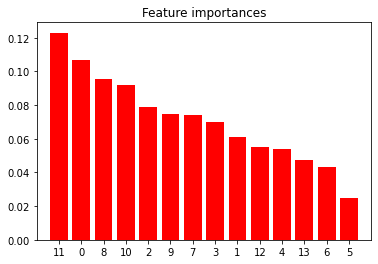

{'kFoldAccuracyScore': -0.12293582774050002,
 'MeanSquareError': 17265289.22766489,
 'meanOfDifferencesInPrediction': 33315.23531888323}

In [151]:
randomForestAccuracy = applyModelToDataframe(meanPerDistrict, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy

Feature ranking:
1. feature 12 (0.126726)
2. feature 3 (0.101306)
3. feature 1 (0.089574)
4. feature 2 (0.087914)
5. feature 11 (0.076352)
6. feature 0 (0.075249)
7. feature 8 (0.074789)
8. feature 4 (0.068453)
9. feature 13 (0.064976)
10. feature 9 (0.056601)
11. feature 10 (0.049911)
12. feature 5 (0.049283)
13. feature 7 (0.043530)
14. feature 6 (0.035336)


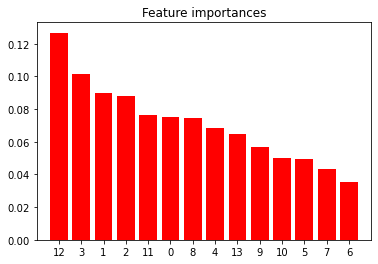

{'kFoldAccuracyScore': -0.3191832362399526,
 'MeanSquareError': 0.05383332249055282,
 'meanOfDifferencesInPrediction': 0.5358652958951435}

In [152]:
randomForestAccuracy = applyModelToDataframe(medianChange, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy

Feature ranking:
1. feature 9 (0.133766)
2. feature 10 (0.130472)
3. feature 4 (0.090718)
4. feature 8 (0.087447)
5. feature 1 (0.085558)
6. feature 0 (0.082170)
7. feature 11 (0.080463)
8. feature 12 (0.067273)
9. feature 2 (0.060770)
10. feature 3 (0.046824)
11. feature 13 (0.043987)
12. feature 7 (0.040911)
13. feature 6 (0.033946)
14. feature 5 (0.015694)


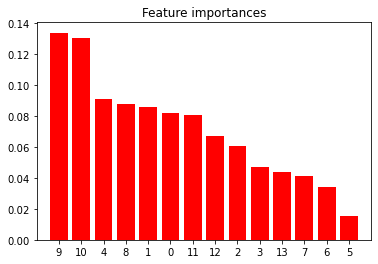

{'kFoldAccuracyScore': -0.5101854503742767,
 'MeanSquareError': 0.06207444212775976,
 'meanOfDifferencesInPrediction': 0.7276099330822088}

In [160]:
randomForestAccuracy = applyModelToDataframe(meanChange, allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy

3594
Feature ranking:
1. feature 11 (0.137235)
2. feature 9 (0.133371)
3. feature 0 (0.098792)
4. feature 6 (0.098112)
5. feature 10 (0.093051)
6. feature 3 (0.076969)
7. feature 2 (0.065465)
8. feature 13 (0.058787)
9. feature 12 (0.055757)
10. feature 8 (0.051385)
11. feature 1 (0.051351)
12. feature 4 (0.030136)
13. feature 7 (0.028118)
14. feature 5 (0.021469)


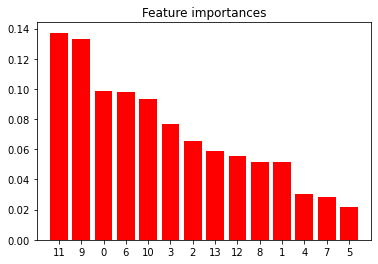

{'kFoldAccuracyScore': -0.0363234237220126,
 'MeanSquareError': 295.2095219006263,
 'meanOfDifferencesInPrediction': 2.158338088106773}

In [156]:
print(len(dfAcctsPctChange.dropna()))
randomForestAccuracy = applyModelToDataframe(dfAcctsPctChange.dropna(), allXColumns, yVector, RandomForestRegressor, True, 'randomForest')
randomForestAccuracy


In [143]:
linearRegressionAccuracy = applyModelToDataframe(dfAcct, allXColumns, yVector, LinearRegression, True)
linearRegressionAccuracy

{'kFoldAccuracyScore': -0.0004838225009787811,
 'MeanSquareError': 299024414.3228751,
 'meanOfDifferencesInPrediction': 34503.21238192444}

In [175]:
balanceRatioSalary =  ['balance']  
yVector = ['district_id']

In [176]:
randomForestClassificationDfAcct = applyModelToDataframe(dfAcct, balanceRatioSalary, yVector, RandomForestClassifier, False )
randomForestClassificationMedian = applyModelToDataframe(medianPerDistrict, balanceRatioSalary, yVector, RandomForestClassifier, False  )
randomForestClassificationMean = applyModelToDataframe(meanPerDistrict, balanceRatioSalary, yVector, RandomForestClassifier, False  )
randomForestClassificationDfAcct_Change = applyModelToDataframe(dfAcctsPctChange.dropna(), balanceRatioSalary, yVector, RandomForestClassifier, False )
randomForestClassificationMedian_Change = applyModelToDataframe(medianChange, balanceRatioSalary, yVector, RandomForestClassifier, False  )
randomForestClassificationMean_Change = applyModelToDataframe(meanChange, balanceRatioSalary, yVector, RandomForestClassifier, False  )



In [177]:
print(f"""
randomForestClassificationDfAcct {randomForestClassificationDfAcct}
randomForestClassificationMedian {randomForestClassificationMedian}
randomForestClassificationMean {randomForestClassificationMean}
randomForestClassificationDfAcct_Change {randomForestClassificationDfAcct_Change}
randomForestClassificationMedian_Change {randomForestClassificationMedian_Change}
randomForestClassificationMean_Change {randomForestClassificationMean_Change}
""")


randomForestClassificationDfAcct {'kFoldAccuracyScore': 0.03157421006950788, 'classificationAcc': 0.031534954407294834, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationMedian {'kFoldAccuracyScore': 0.019471715755025713, 'classificationAcc': 0.03597122302158273, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationMean {'kFoldAccuracyScore': 0.006474988312295466, 'classificationAcc': 0.0, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationDfAcct_Change {'kFoldAccuracyScore': 0.02253710469121071, 'classificationAcc': 0.025023169601482854, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationMedian_Change {'kFoldAccuracyScore': 0.0, 'classificationAcc': 0.0, 'meanOfDifferencesInPrediction': 0.0}
randomForestClassificationMean_Change {'kFoldAccuracyScore': 0.0, 'classificationAcc': 0.0, 'meanOfDifferencesInPrediction': 0.0}



In [21]:
someData = preprocessing.loadAllData(filePath, True)

In [22]:
loanDF = someData[someData['status'].notna()].drop(['card_id', 'type_y', 'issued', 'date_y', 'date_x', 'issued', 'type_y', 'issued'], axis=1)
loanDF[loanDF['district_id' ]==15]

,account_id,district_id,frequency,disp_id,client_id,type_x,gender,birth_date,district_id_y,loan_id,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
856,314,15,2,383,383,0,0,-9.665424e+08,15,5039.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
857,314,15,2,384,384,1,1,-1.080328e+09,15,5039.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
906,4825,15,0,5826,5826,0,1,-4.137120e+07,15,5980.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
907,4825,15,0,5827,5827,1,0,1.601172e+08,15,5980.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
908,5283,15,0,6383,6383,0,1,5.364000e+05,15,6078.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
910,5572,15,0,6729,6729,0,1,-3.791052e+08,15,6136.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
911,5593,15,0,6753,6753,0,1,-2.401776e+08,15,6144.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
912,5927,15,0,7166,7166,0,1,-1.778832e+08,15,6210.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879
915,11265,15,0,13537,13845,0,1,9.868680e+07,15,7284.0,...,7,1,5,51.9,9045,3.1,3.6,124,1845.0,1879


In [23]:
for column in loanDF.columns: 
    if len(loanDF[loanDF[column].isna()]) > 0: 
        print(column)

Feature ranking:
1. feature 11 (0.160992)
2. feature 10 (0.101365)
3. feature 12 (0.081330)
4. feature 3 (0.057732)
5. feature 7 (0.055574)
6. feature 0 (0.055480)
7. feature 9 (0.051808)
8. feature 4 (0.050353)
9. feature 8 (0.036484)
10. feature 24 (0.029958)
11. feature 21 (0.026782)
12. feature 14 (0.025565)
13. feature 1 (0.024738)
14. feature 16 (0.023833)
15. feature 23 (0.023065)
16. feature 22 (0.021905)
17. feature 15 (0.021536)
18. feature 17 (0.020439)
19. feature 20 (0.020095)
20. feature 25 (0.019846)
21. feature 26 (0.019742)
22. feature 2 (0.018210)
23. feature 19 (0.016096)
24. feature 6 (0.011687)
25. feature 13 (0.010675)
26. feature 18 (0.009744)
27. feature 5 (0.004968)


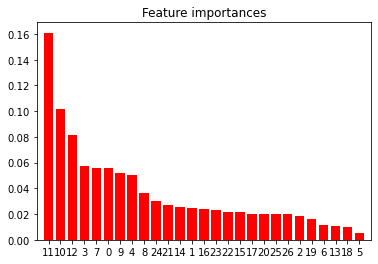

{'kFoldAccuracyScore': 0.7533187294633078,
 'classificationAcc': 0.7188755020080321,
 'meanOfDifferencesInPrediction': 0.0}

In [179]:
accuracy=applyModelToDataframe(loanDF, ['account_id', 'district_id', 'frequency', 'disp_id', 'client_id', 'type_x', 
                                        'gender', 'birth_date', 'district_id_y', 'loan_id', 'amount',
                                       'duration', 'payments', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8',
                                       'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16'], ['status'], RandomForestClassifier, False, 'randomForest')
accuracy

Feature ranking:
1. feature 0 (0.414334)
2. feature 2 (0.392012)
3. feature 1 (0.193654)


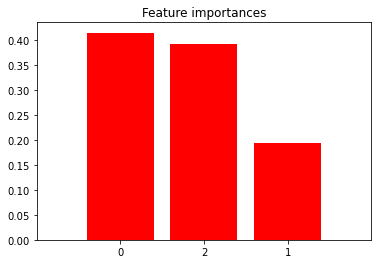

{'kFoldAccuracyScore': 0.6844103687477181,
 'classificationAcc': 0.7028112449799196,
 'meanOfDifferencesInPrediction': 0.0}

In [180]:
accuracy=applyModelToDataframe(loanDF, ['amount', 'duration', 'payments'], ['status'], RandomForestClassifier, False, 'randomForest')
accuracy

Feature ranking:
1. feature 5 (0.223459)
2. feature 6 (0.208819)
3. feature 7 (0.187954)
4. feature 3 (0.164929)
5. feature 4 (0.141401)
6. feature 0 (0.033157)
7. feature 2 (0.025164)
8. feature 1 (0.015118)


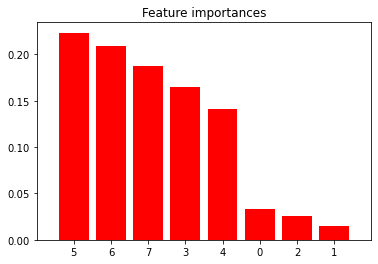

{'kFoldAccuracyScore': 0.707316538882804,
 'classificationAcc': 0.7108433734939759,
 'meanOfDifferencesInPrediction': 0.0}

In [183]:
xCols =  [ 'frequency', 'type_x', 'gender', 'birth_date', 'district_id_y',
            'amount', 'duration', 'payments']
yCol = [ 'status' ]

acc = applyModelToDataframe(loanDF, xCols, yCol, RandomForestClassifier, False, 'randomForest')
acc

Feature ranking:
1. feature 0 (1.000000)


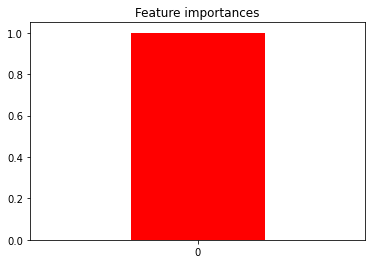

{'kFoldAccuracyScore': 0.7146476816356334,
 'classificationAcc': 0.7188755020080321,
 'meanOfDifferencesInPrediction': 0.0}

In [188]:
acc = applyModelToDataframe(loanDF, ['duration' ], yCol, RandomForestClassifier, False, 'randomForest')
acc

['frequency',
 'type_x',
 'gender',
 'birth_date',
 'district_id_y',
 'amount',
 'duration',
 'payments']

Feature ranking:
1. feature 5 (0.220886)
2. feature 6 (0.209401)
3. feature 7 (0.193545)
4. feature 3 (0.159055)
5. feature 4 (0.143645)
6. feature 0 (0.031053)
7. feature 2 (0.026731)
8. feature 1 (0.015683)


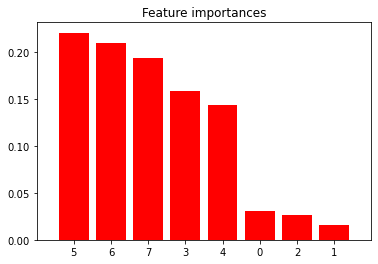

{'kFoldAccuracyScore': 0.7049142022635998,
 'classificationAcc': 0.6907630522088354,
 'meanOfDifferencesInPrediction': 0.0}

In [191]:
yCol = [ 'status' ]
acc = applyModelToDataframe(loanDF, xCols, yCol, RandomForestClassifier, False, 'randomForest')
acc

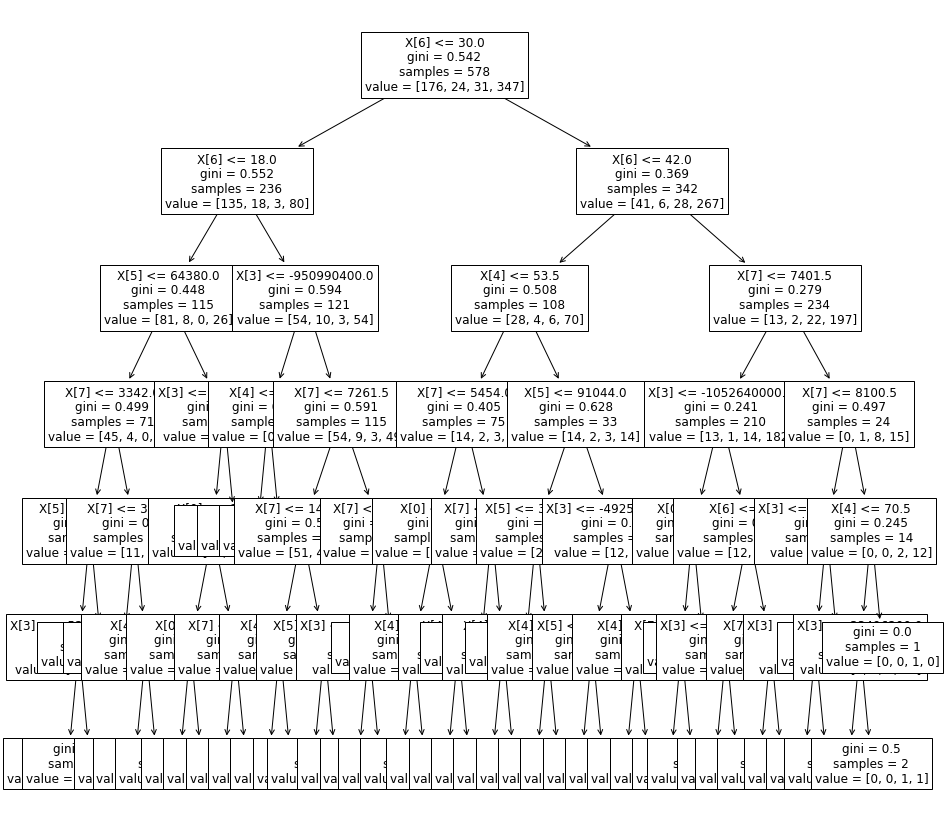

{'kFoldAccuracyScore': 0.6988901058780577,
 'classificationAcc': 0.6827309236947792,
 'meanOfDifferencesInPrediction': 0.0}

In [192]:
acc = applyModelToDataframe(loanDF, xCols, yCol, lambda: DecisionTreeClassifier(max_depth=6), False, 'decisionTree')
acc

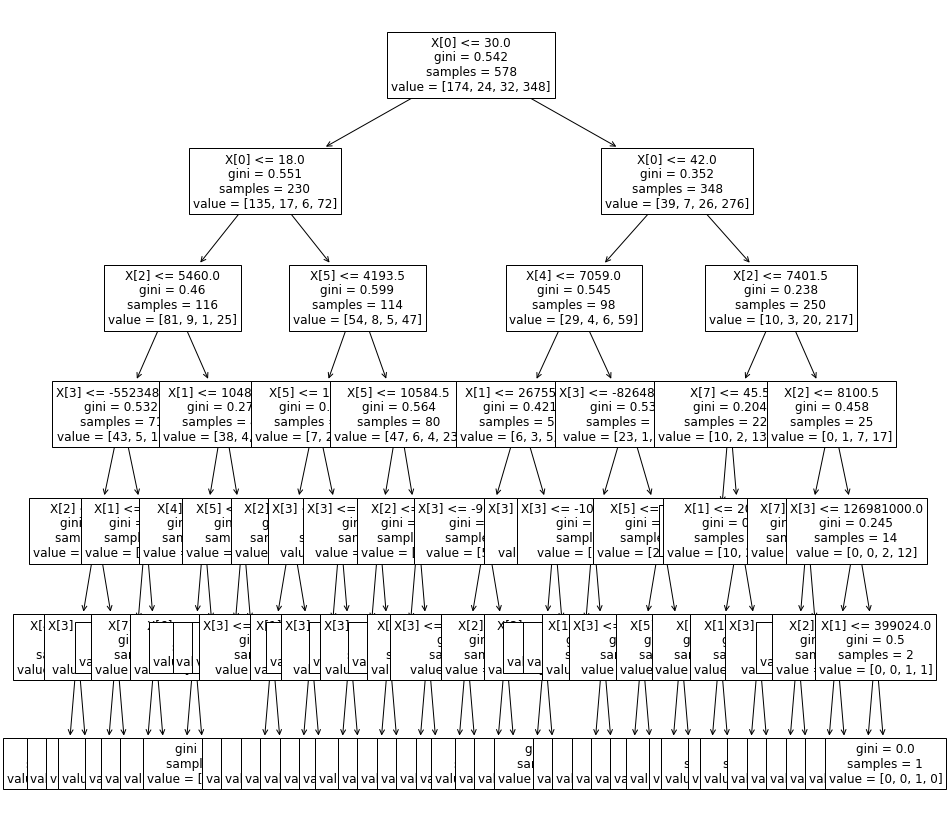

{'kFoldAccuracyScore': 0.6989047097480833,
 'classificationAcc': 0.6827309236947792,
 'meanOfDifferencesInPrediction': 0.0}

In [193]:
acc = applyModelToDataframe(loanDF, higherAccCols, yCol, lambda: DecisionTreeClassifier(max_depth=6), False, 'decisionTree')
acc

In [197]:
acc = applyModelToDataframe(loanDF, xCols, yCol, lambda: KNeighborsClassifier(n_neighbors=int(np.sqrt(len(loanDF)))), False)
acc

{'kFoldAccuracyScore': 0.5744140197152244,
 'classificationAcc': 0.5461847389558233,
 'meanOfDifferencesInPrediction': 0.0}

In [207]:
meanChange[meanChange['balance'] > 1]

,district_id,numInhabitants,municipalitiesLess500,municipalities500to2k,municipalities2kto10k,municipalitiesGreater10k,numCities,ratioUrbanInhabitants,avgSalary,unEmployment95,unEmployment96,entrepeneursPer1k,crimesIn95,crimesIn96,balance
33,34,125236,28,11,1,4,5,87.7,9675,6.4,7.68,100,5323.0,5190,1.005025


In [209]:
import networkx as nx


,district_id,numInhabitants,municipalitiesLess500,municipalities500to2k,municipalities2kto10k,municipalitiesGreater10k,numCities,ratioUrbanInhabitants,avgSalary,unEmployment95,unEmployment96,entrepeneursPer1k,crimesIn95,crimesIn96,balance
district_id,1.000000,0.024198,-0.192888,0.351801,0.346569,0.277642,0.022941,0.007019,-0.256033,0.442908,0.436070,-0.455890,-0.109685,-0.129428,0.016993
numInhabitants,0.024198,1.000000,-0.306117,-0.194369,-0.098136,0.043197,-0.273442,0.453271,0.639834,-0.113531,-0.116989,0.264873,0.977430,0.972490,0.052361
municipalitiesLess500,-0.192888,-0.306117,1.000000,0.214798,-0.165852,-0.207606,0.052394,-0.452779,-0.341332,-0.197594,-0.197596,-0.085878,-0.298102,-0.280440,-0.201623
municipalities500to2k,0.351801,-0.194369,0.214798,1.000000,0.577452,0.082513,0.340066,-0.632699,-0.403481,-0.041827,-0.061180,-0.093302,-0.287224,-0.276912,0.014597
municipalities2kto10k,0.346569,-0.098136,-0.165852,0.577452,1.000000,0.041362,0.502612,-0.351328,-0.189056,-0.041328,-0.035110,-0.140230,-0.204655,-0.205466,0.026585
municipalitiesGreater10k,0.277642,0.043197,-0.207606,0.082513,0.041362,1.000000,0.243540,0.254950,-0.029226,0.408180,0.421098,-0.346697,-0.022120,-0.030997,0.142116
numCities,0.022941,-0.273442,0.052394,0.340066,0.502612,0.243540,1.000000,-0.037301,-0.275483,-0.126154,-0.123141,-0.046059,-0.310758,-0.303608,0.026269
ratioUrbanInhabitants,0.007019,0.453271,-0.452779,-0.632699,-0.351328,0.254950,-0.037301,1.000000,0.599725,0.134112,0.159183,0.041719,0.443525,0.416620,0.162643
avgSalary,-0.256033,0.639834,-0.341332,-0.403481,-0.189056,-0.029226,-0.275483,0.599725,1.000000,-0.093388,-0.090869,0.269185,0.651638,0.634388,0.143168
unEmployment95,0.442908,-0.113531,-0.197594,-0.041827,-0.041328,0.408180,-0.126154,0.134112,-0.093388,1.000000,0.980377,-0.503198,-0.139496,-0.150695,0.297819


In [245]:
def generateCorrelationMatrix(df, threshold=0.5): 
# Calculate the correlation between individuals. We have to transpose first, because the corr function calculate the pairwise correlations between columns.
    corr = df.corr()
    corr
# Transform it in a links data frame (3 columns only):
    links = corr.stack().reset_index()
    links.columns = ['var1', 'var2','value']
    links

    # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
    links_filteredNegative=links.loc[ (links['value'] <  -threshold) & (links['var1'] != links['var2']) ]
    links_filteredPos=links.loc[ (links['value'] > threshold) & (links['var1'] != links['var2']) ]

    # Build your graph
    Gneg=nx.from_pandas_edgelist(links_filteredNegative, 'var1', 'var2')
    Gpos=nx.from_pandas_edgelist(links_filteredPos, 'var1', 'var2')

    # Plot the network:
    plt.figure(figsize=(5,6))
    nx.draw(Gneg, with_labels=True, node_color='lightcoral', node_size=700, edge_color='black', linewidths=1, font_size=10)
    nx.draw(Gpos, with_labels=True, node_color='cornflowerblue', node_size=700, edge_color='black', linewidths=1, font_size=10)
    plt.show()

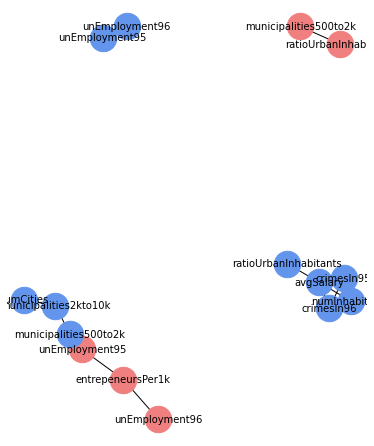

In [246]:
generateCorrelationMatrix(meanChange)

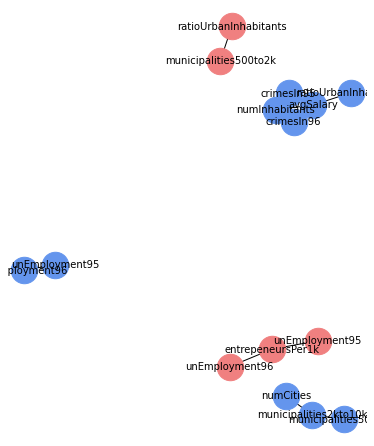

In [247]:
generateCorrelationMatrix(medianChange)

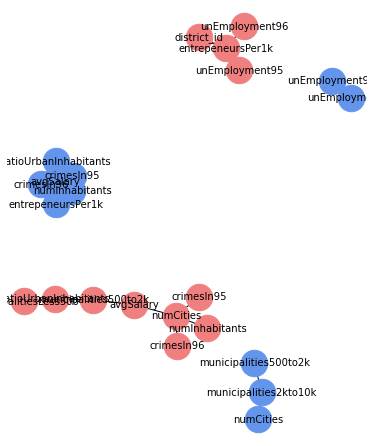

In [249]:
generateCorrelationMatrix(dfAcctsPctChange,0.6)

In [250]:
meanChange.corr()

,district_id,numInhabitants,municipalitiesLess500,municipalities500to2k,municipalities2kto10k,municipalitiesGreater10k,numCities,ratioUrbanInhabitants,avgSalary,unEmployment95,unEmployment96,entrepeneursPer1k,crimesIn95,crimesIn96,balance
district_id,1.000000,0.024198,-0.192888,0.351801,0.346569,0.277642,0.022941,0.007019,-0.256033,0.442908,0.436070,-0.455890,-0.109685,-0.129428,0.016993
numInhabitants,0.024198,1.000000,-0.306117,-0.194369,-0.098136,0.043197,-0.273442,0.453271,0.639834,-0.113531,-0.116989,0.264873,0.977430,0.972490,0.052361
municipalitiesLess500,-0.192888,-0.306117,1.000000,0.214798,-0.165852,-0.207606,0.052394,-0.452779,-0.341332,-0.197594,-0.197596,-0.085878,-0.298102,-0.280440,-0.201623
municipalities500to2k,0.351801,-0.194369,0.214798,1.000000,0.577452,0.082513,0.340066,-0.632699,-0.403481,-0.041827,-0.061180,-0.093302,-0.287224,-0.276912,0.014597
municipalities2kto10k,0.346569,-0.098136,-0.165852,0.577452,1.000000,0.041362,0.502612,-0.351328,-0.189056,-0.041328,-0.035110,-0.140230,-0.204655,-0.205466,0.026585
municipalitiesGreater10k,0.277642,0.043197,-0.207606,0.082513,0.041362,1.000000,0.243540,0.254950,-0.029226,0.408180,0.421098,-0.346697,-0.022120,-0.030997,0.142116
numCities,0.022941,-0.273442,0.052394,0.340066,0.502612,0.243540,1.000000,-0.037301,-0.275483,-0.126154,-0.123141,-0.046059,-0.310758,-0.303608,0.026269
ratioUrbanInhabitants,0.007019,0.453271,-0.452779,-0.632699,-0.351328,0.254950,-0.037301,1.000000,0.599725,0.134112,0.159183,0.041719,0.443525,0.416620,0.162643
avgSalary,-0.256033,0.639834,-0.341332,-0.403481,-0.189056,-0.029226,-0.275483,0.599725,1.000000,-0.093388,-0.090869,0.269185,0.651638,0.634388,0.143168
unEmployment95,0.442908,-0.113531,-0.197594,-0.041827,-0.041328,0.408180,-0.126154,0.134112,-0.093388,1.000000,0.980377,-0.503198,-0.139496,-0.150695,0.297819


In [252]:
meanChange.corr()['balance']

district_id                 0.016993
numInhabitants              0.052361
municipalitiesLess500      -0.201623
municipalities500to2k       0.014597
municipalities2kto10k       0.026585
municipalitiesGreater10k    0.142116
numCities                   0.026269
ratioUrbanInhabitants       0.162643
avgSalary                   0.143168
unEmployment95              0.297819
unEmployment96              0.286654
entrepeneursPer1k          -0.180079
crimesIn95                  0.051058
crimesIn96                  0.044184
balance                     1.000000
Name: balance, dtype: float64